In [33]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout


In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Load SOC data from CSV with downsampling
def load_soc_data(file_path, downsample_factor=10):
    df = pd.read_csv(file_path)

    # Apply downsampling - use every Nth row
    df = df.iloc[::downsample_factor]

    # Extract voltage, current, and SOC columns
    voltage = df['voltage (V)'].values
    current = df['current (A)'].values
    soc = df['SOC'].values

    # Combine into a single array for the model: [voltage, current, SOC]
    data = np.column_stack((voltage, current, soc))
    
    return data

# Load and prepare data with downsampling
soc_data = load_soc_data("new_train_data.csv", downsample_factor=20)

# Cap the total size to reduce memory usage
max_samples = min(10000, len(soc_data))
soc_data = soc_data[:max_samples]

# Split into train, validation, and test sets
total_samples = len(soc_data)
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)

train_data = soc_data[:train_size]
val_data = soc_data[train_size:train_size+val_size]
test_data = soc_data[train_size+val_size:]

print(f"Original data downsampled by factor of 20")
print(f"Limited to {max_samples} total samples")
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

# Create trajectories
def create_trajectories(data, length):
    trajectories = []
    for i in range(0, len(data) - length + 1):
        trajectories.append(data[i:i+length])
    return np.array(trajectories)

trajLength = 256  # Length of each trajectory
input_dim = 3     # Voltage, Current, SOC

if len(train_data) > trajLength * 2:
    train_trajectories = create_trajectories(train_data, trajLength)
    val_trajectories = create_trajectories(val_data, trajLength)
    test_trajectories = create_trajectories(test_data, trajLength)

    numTraj = len(train_trajectories)
    numTraj_val = len(val_trajectories)

    train_data = train_trajectories
    val_data = val_trajectories
    test_data = test_trajectories

else:
    numTraj = 1
    numTraj_val = 1

print("After trajectory creation:")
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

# Batch and prediction config
batch_size = min(256, len(train_data) // 2)
S = 50

num_batches_train = max(1, int((trajLength * numTraj) / batch_size))
num_batches_val = max(1, int((trajLength * numTraj_val) / batch_size))

print("Batch size:", batch_size)
print("Number of training batches:", num_batches_train)
print("Number of validation batches:", num_batches_val)

# Normalize data per feature using training set stats
min_train = tf.reduce_min(train_data, axis=[0, 1])
max_train = tf.reduce_max(train_data, axis=[0, 1])

train_data = (train_data - min_train.numpy()) / (max_train.numpy() - min_train.numpy())
val_data = (val_data - min_train.numpy()) / (max_train.numpy() - min_train.numpy())
test_data = (test_data - min_train.numpy()) / (max_train.numpy() - min_train.numpy())

# Convert to TensorFlow format
train_data = tf.cast(train_data, tf.float32)
val_data = tf.cast(val_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_data)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_data)).batch(batch_size)

Original data downsampled by factor of 20
Limited to 7983 total samples
Train data shape: (5588, 3)
Validation data shape: (1197, 3)
Test data shape: (1198, 3)
After trajectory creation:
Train data shape: (5333, 256, 3)
Validation data shape: (942, 256, 3)
Test data shape: (943, 256, 3)
Batch size: 256
Number of training batches: 5333
Number of validation batches: 942


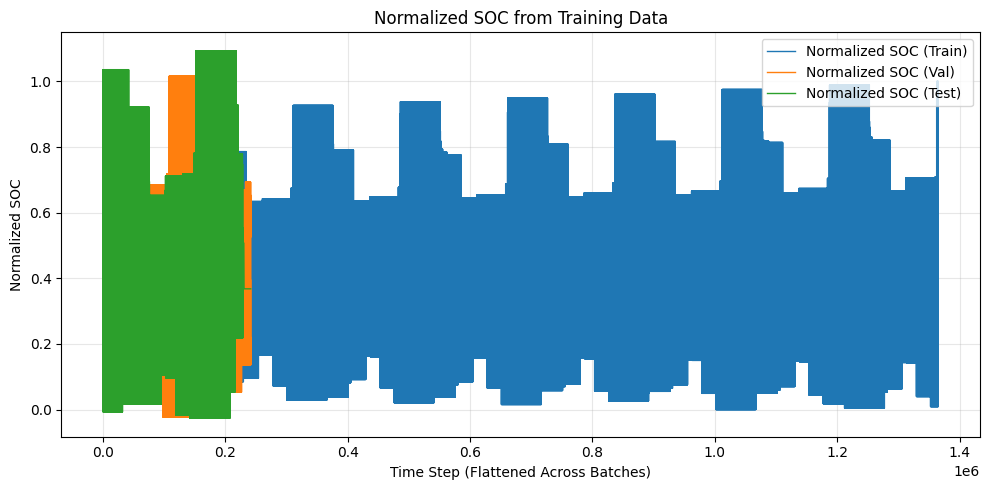

In [35]:
import matplotlib.pyplot as plt

# Extract the SOC column (index 1) across all time steps and batches
# Flatten it if needed, depending on your data shape
soc_flat = tf.reshape(train_data[:, :, 1], [-1]).numpy()  # SOC is column 1
soc_flat2 = tf.reshape(val_data[:, :, 1], [-1]).numpy()  # SOC is column 1
soc_flat3 = tf.reshape(test_data[:, :, 1], [-1]).numpy()  # SOC is column 1

# Plot normalized SOC
plt.figure(figsize=(10, 5))
plt.plot(soc_flat, label='Normalized SOC (Train)', linewidth=1)
plt.plot(soc_flat2, label='Normalized SOC (Val)', linewidth=1)
plt.plot(soc_flat3, label='Normalized SOC (Test)', linewidth=1)

plt.xlabel('Time Step (Flattened Across Batches)')
plt.ylabel('Normalized SOC')
plt.title('Normalized SOC from Training Data')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
class EncoderModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.dense1 = Dense(500, activation="relu")
        self.dense2 = Dense(32, activation="tanh") 
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(0.1) 

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.layer_norm(x)  # Apply LayerNormalization after the dense layer
        x = self.dropout(x)
        return x

In [37]:
# Koopman Layer
class KoopmanLayer(keras.layers.Layer):
    def __init__(self, S):
        super(KoopmanLayer, self).__init__()
        self.S = S

    def build(self, input_shape):
        self.latent_dim = input_shape[-1]  # e.g. 32
        self.K = self.add_weight(
            name="Koopman_weight",
            shape=(self.latent_dim, self.latent_dim),
            initializer="random_normal",
            trainable=True,
        )

    def call(self, Z):
        # Z shape: (batch_size, S, latent_dim)
        batch_size = tf.shape(Z)[0]

        z0 = Z[:, 0, :]  # Initial state: shape (batch_size, latent_dim)

        # Use Koopman operator to propagate z0 for S steps
        Z2_tilde = tf.TensorArray(dtype=tf.float32, size=self.S)
        z_t = z0
        for t in range(self.S):
            Z2_tilde = Z2_tilde.write(t, z_t)
            z_t = tf.matmul(z_t, self.K)  # batch-wise matmul

        # Convert to shape (batch_size, S, latent_dim)
        Z2_tilde = tf.transpose(Z2_tilde.stack(), perm=[1, 0, 2])

        z_shift = Z[:, 1:, :]  # Ground truth: z(t+1), z(t+2), ...

        return Z, Z2_tilde, z_shift


# Koopman Model
class KoopmanModel(keras.Model):
    def __init__(self, S):
        super(KoopmanModel, self).__init__()
        self.koopman = KoopmanLayer(S)

    def call(self, z):
        z, Z2_tilde, z_shift = self.koopman(z) 
        
        #z: Latent variables of x in the lifted space
        #z2_tilde: Latent variables of prediction obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
        return z,Z2_tilde,z_shift  # Pass only transformed output to the decoder

In [45]:
class DecoderModel(keras.Model):
    def __init__(self):
        super().__init__()
        # self.dense = Dense(500, activation="relu")
        self.dense_recon = Dense(500, activation="relu")
        self.dense_pred = Dense(500, activation="relu")
        self.output_layer = Dense(3)  # instead of 3


    def call(self, input1, input2):
        z = input1
        z2_tilde = input2
        
        x = self.dense_recon(z)
        x2 = self.dense_pred(z2_tilde)

        return self.output_layer(x), self.output_layer(x2)

In [46]:
# class DecoderModel(keras.Model):
#     def __init__(self):
#         super().__init__()
#         self.dense = Dense(500, activation="relu")
#         self.output_layer = Dense(3)  

#     def call(self, input1, input2):
#         z = input1
#         z2_tilde = input2
        
#         x = self.dense(z)
#         x2 = self.dense(z2_tilde)

#         return self.output_layer(x), self.output_layer(x2)

In [47]:
class Koopman_AE_Model(keras.Model):
    """
    Custom Model to create a Koopman Autoencoder
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Predcition of the original state inputs x (label values are forward time shifted x)
    
    x2_tilde: tensor
        Prediction obtained by linearity from K 
    """
    
    def __init__(self, S, name=None):
        super(Koopman_AE_Model, self).__init__(name=name)
        self.enc = EncoderModel()
        self.koopman = KoopmanModel(S)
        self.dec = DecoderModel()

    def call(self, input):
        x = input
        z = self.enc(x)
        z, z2_tilde, z2 = self.koopman(z)
        x_hat, x2_tilde = self.dec(z, z2_tilde)
        return x_hat, x2_tilde


In [70]:
import time

class MyStaticModel():
    def __init__(self, input_dim, batch_size, S, num_batches_train, num_batches_val):
        # Initialize constants
        self.batch_size = batch_size
        self.S = S
        self.num_batches_train = num_batches_train
        self.num_batches_val = num_batches_val

        self.inputs = tf.keras.layers.Input(shape=(input_dim,))
        
    ######################################  LOSS FUNCTIONS  ###################################################

    def tot_loss(self, model, x, x_hat, x2_tilde):
        """Calculates total loss as sum of recon_loss + predict_loss + Koopman_loss"""
        alpha1 = 1.0
        alpha2 = 10.0
        alpha3 = 1e-6
        
        # Get the shape of x2_tilde to make sure x2 matches
        tilde_shape = tf.shape(x2_tilde)
        
        # Slice the input to match the prediction shape
        # This ensures we compare the same time steps
        # x2 = x[:tilde_shape[0], 1:self.S+1]
        x2 = x[:, 1:self.S+1, :]  # Slice time steps along axis 1

        
        recon_loss = tf.reduce_mean(tf.square(tf.subtract(x,x_hat)))
        # recon_loss = tf.reduce_mean(tf.abs(tf.subtract(x, x_hat)))
        predict_loss = tf.reduce_mean(tf.square(tf.subtract(x2,x2_tilde)))
        weights = model.trainable_variables
        lossL2 = tf.add_n([tf.nn.l2_loss(w) for w in weights if 'bias' not in w.name])
        
        return alpha1*recon_loss + alpha2*predict_loss + alpha3*lossL2
        
    ###############################################     FIT FUNCTION        #########################################################

    def fit(self, model, x, y, validation_data, batch_size):
        # Preprocess data
        train_ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)
        # Define the optimizer
        optimizer = tf.keras.optimizers.Adam(0.0001)

        epochs = 10  
        
        epoch_train_loss = [] # total loss for each epoch
        epoch_validation_loss = []

        start_time_total = time.time()
        for epoch in range(epochs):
                
            print("\nStart of epoch %d" % (epoch))
            start_time = time.time()

            batch_train_loss_list = [] # total loss for each batch 
            batch_validation_loss_list = []

            epoch_train_min_loss = []
            epoch_train_max_loss = []
            epoch_validation_min_loss = []
            epoch_validation_max_loss = []

            ###############################################     Training loop     ###################################################
            # Iterate over the train batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
                with tf.GradientTape() as tape:
                    reconstruction, linearity= model(x_batch_train)
                    # total avg loss for each batch
                    batch_train_loss = self.tot_loss(model, y_batch_train, reconstruction, linearity)
                    batch_train_loss_list.append(batch_train_loss)

                grads = tape.gradient(batch_train_loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                              
            # outside batch loop
            avg_train_loss = np.sum(batch_train_loss_list)/self.num_batches_train
            avg_min_train_loss = np.amin(batch_train_loss_list)/self.num_batches_train
            avg_max_train_loss = np.amax(batch_train_loss_list)/self.num_batches_train

            epoch_train_loss.append(avg_train_loss)
            epoch_train_min_loss.append(avg_min_train_loss)
            epoch_train_max_loss.append(avg_max_train_loss)
            print("Average training loss at epoch %d: %.7f"% (epoch, float(avg_train_loss)))


            ###############################################   Validaiton  loop     ###################################################
            for step, (x_batch_val, y_batch_val) in enumerate(validation_data):
                reconstruction_val, linearity_val= model(x_batch_val)
                batch_validation_loss = self.tot_loss(model, y_batch_val, reconstruction_val, linearity_val)
                batch_validation_loss_list.append(batch_validation_loss)

            # outside batch loop
            epoch_validation_loss.append(np.sum(batch_validation_loss_list)/self.num_batches_val)
            epoch_validation_min_loss.append(np.amin(batch_validation_loss_list)/self.num_batches_val)
            epoch_validation_max_loss.append(np.amax(batch_validation_loss_list)/self.num_batches_val)

            print(f"Epoch val loss: {np.sum(batch_validation_loss_list)/num_batches_val}")
            print("Time taken: %.2fs" % (time.time()- start_time_total))

        print("Total time taken: %.2fs" % (time.time() - start_time_total))



In [71]:
print(train_data.shape)  # should be like (2048, 30, 2) or similar

(5333, 256, 3)


In [72]:
# dummy_input = tf.random.normal([batch_size, trajLength, input_dim])
# z = koopmanAEModel.enc(dummy_input)
# print("Encoder output shape:", z.shape)


In [73]:
koopmanAEModel = Koopman_AE_Model(S)
Training_class = MyStaticModel(input_dim, batch_size, S, num_batches_train, num_batches_val)
Training_class.fit(
    koopmanAEModel,
    x=train_data,
    y=train_data,
    validation_data=tf.data.Dataset.from_tensor_slices((val_data, val_data)).batch(batch_size),
    batch_size=batch_size
)



Start of epoch 0
Average training loss at epoch 0: 0.0124248
Epoch val loss: 0.00308481371326811
Time taken: 18.95s

Start of epoch 1
Average training loss at epoch 1: 0.0108412
Epoch val loss: 0.0027657995304990472
Time taken: 37.25s

Start of epoch 2
Average training loss at epoch 2: 0.0100329
Epoch val loss: 0.00256390733577137
Time taken: 56.05s

Start of epoch 3
Average training loss at epoch 3: 0.0092691
Epoch val loss: 0.002450731403002567
Time taken: 74.95s

Start of epoch 4
Average training loss at epoch 4: 0.0084925
Epoch val loss: 0.002355938504455955
Time taken: 95.33s

Start of epoch 5
Average training loss at epoch 5: 0.0077102
Epoch val loss: 0.0022933189529775306
Time taken: 115.32s

Start of epoch 6
Average training loss at epoch 6: 0.0069295
Epoch val loss: 0.002263994733239435
Time taken: 133.80s

Start of epoch 7
Average training loss at epoch 7: 0.0061637
Epoch val loss: 0.0022943462788932137
Time taken: 151.99s

Start of epoch 8
Average training loss at epoch 8: 

In [74]:
K = koopmanAEModel.koopman.get_weights()
print(K)

[array([[-0.00784348,  0.02057154,  0.05224192, ...,  0.05901271,
         0.01979079, -0.03260417],
       [ 0.02266335,  0.05340436,  0.03974228, ...,  0.01396479,
         0.01459739,  0.09173009],
       [ 0.03544727,  0.01400412,  0.03896066, ...,  0.03272232,
        -0.04584847,  0.00723379],
       ...,
       [-0.01600877,  0.03954286, -0.05462631, ...,  0.0984133 ,
        -0.06820211, -0.08668037],
       [ 0.02360886, -0.01224628,  0.00456376, ...,  0.02535792,
        -0.05472013, -0.07671776],
       [-0.01898289, -0.03344258, -0.02177238, ..., -0.02123353,
        -0.04336209,  0.01405274]], dtype=float32)]


In [75]:
test_data.shape

TensorShape([943, 256, 3])

In [76]:
def visualize_soc_results(model, test_data):
    """
    Visualize SOC model results comparing:
    - Actual input
    - Reconstruction
    - Predicted next steps using Koopman operator
    """

    # Select one trajectory
    sample_idx = 0
    sample = test_data[sample_idx:sample_idx+1]  # Keep batch dimension

    # Get model outputs
    x_hat, x2_tilde = model(sample)

    # Convert to numpy and remove batch dimension
    sample_np = sample.numpy()[0]
    x_hat_np = x_hat.numpy()[0]
    x2_tilde_np = x2_tilde.numpy()[0]

    # Actual next-step (shifted input by 1 timestep)
    x2_actual = sample_np[1:]  # Remove first point
    x2_tilde_plot = x2_tilde_np[:len(x2_actual)]  # Trim prediction to match

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))

    # Plot SOC (dimension 1)
    axes[0].plot(sample_np[:, 1], label='SOC - Actual Input', color='blue')
    print(sample_np[:, 1].shape)
    axes[0].plot(x_hat_np[:, 1], '--', label='SOC - Reconstruction', color='red')
    axes[0].set_title("SOC: Actual Input vs Reconstruction")
    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel("Normalized Value")
    axes[0].legend()

    # Plot next-step prediction
    axes[1].plot(range(1, len(sample_np)), x2_actual[:, 1], label='SOC - Actual Next Steps', color='green')
    axes[1].plot(range(1, 1 + len(x2_tilde_plot)), x2_tilde_plot[:, 1], '--', label='SOC - Koopman Prediction', color='orange')
    axes[1].set_title("SOC: Next-Step Prediction using Koopman Operator")
    axes[1].set_xlabel("Time Step")
    axes[1].set_ylabel("Normalized Value")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


(256,)


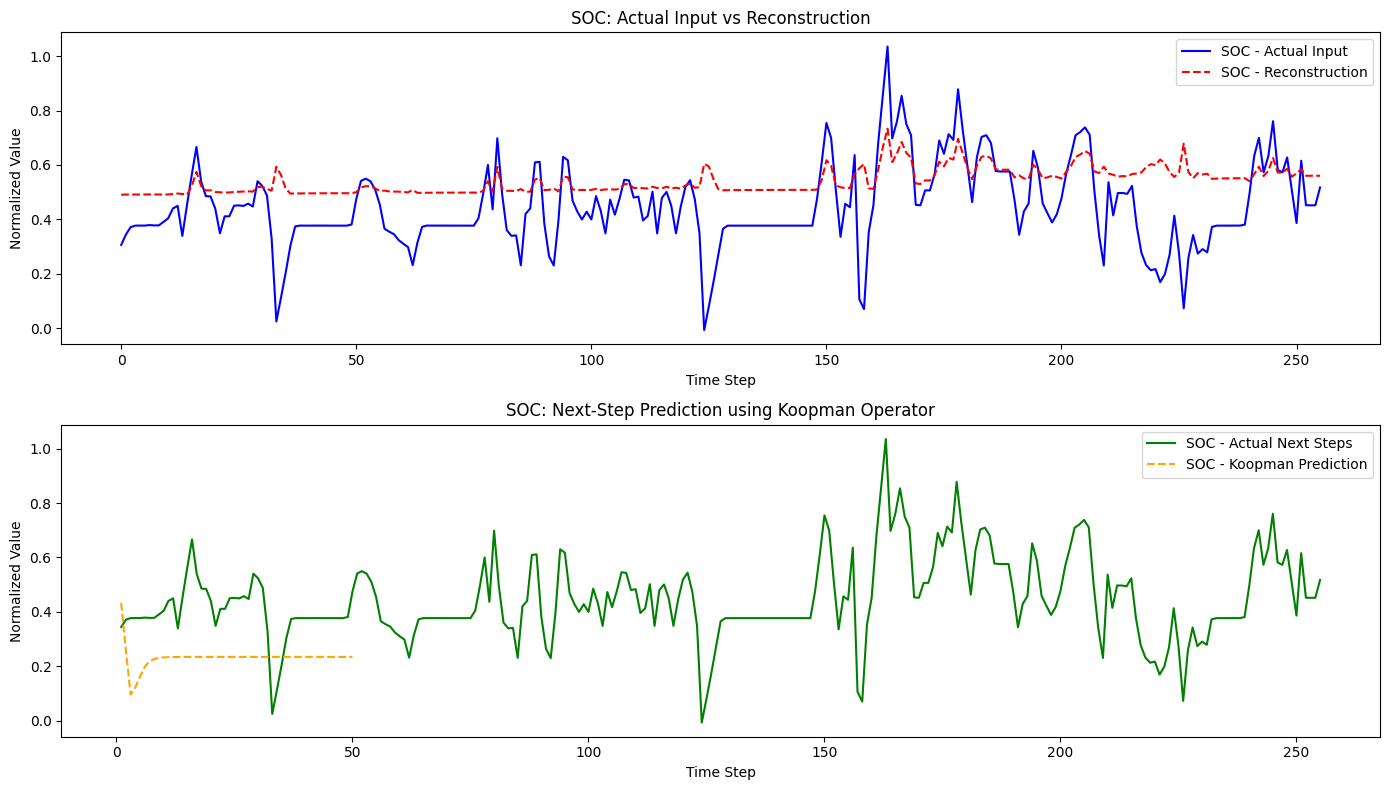

In [77]:
# Usage:
visualize_soc_results(koopmanAEModel, test_data)